## AWS Interviewee: David Ramirez

### Data Science Case Study Options 

Please select and complete one of the following case studies. We are looking for you to show off your  machine learning and coding skills using Python or R. You are not required to use AWS in your solution,  but you are welcome to spin up an EC2 instance if you would like to. If you use any AWS services please  remember to terminate them after you complete the exercise. 

Please Note: 
- Do not post solution on GitHub or any other online public site 
- Submit a work sample that is comprehensive with respect to your thought process, code, findings,  and recommendations (ie a notebook with annotations). You may submit other documents if you wish. 

Please send the completed work sample at least 1 days prior to the virtual interview. On the day of the  interview you will need access to a laptop/desktop as you will be sharing your screen and going through  the work sample with the interviewer. 
Please send a document displaying your code, annotations, and thought process in a PDF to  kdalenbe@amazon.com and CC your recruiter at least 24 hours prior to your interview. 

### Option 2: Geological Image Similarity 

BACKGROUND 
A geology research company wants to create a tool for identifying interesting patterns in their imagery  data. This tool will possess a search capability whereby an analyst provides an image of interest and is  presented with other images which are similar to it.

GOAL 
Your task is to create the machine learning component for this image similarity application. The machine  learning model should return the top K images that are most similar to this image based on a single  image input.

In [4]:
import os 

from urllib import request
import zipfile
import shutil

from PIL import Image, ImageOps
import pandas as pd
import pathlib
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib inline

from MulticoreTSNE import MulticoreTSNE as TSNE

import cv2
import torch
import torchvision
from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor
from pandas.core.common import flatten
import random
from sklearn.neighbors import NearestNeighbors

In [5]:
# Look what's in the project folder

cwd_path = os.getcwd()
print('Project Folder:')
print(cwd_path)
print("\nProject Content:")
print("\n".join(sorted(os.listdir())))

Project Folder:
/home/david/Documents/projects/aws_geo_sim

Project Content:
.ipynb_checkpoints
README.md
aws_geo_sim.ipynb
aws_geo_sim.pdf
data
data_setup.ipynb
geological_similarity.zip
pixel_analysis.ipynb
pixel_tsne.ipynb
requirements.yml
vision_transformer.ipynb


    # Download the data and unzip 

    zip_url='http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip'
    zip_path = os.path.join(cwd_path,'geological_similarity.zip')
    request.urlretrieve(zip_url, zip_path)

    os.mkdir('data')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

In [6]:
# Set data path and ensure exists

data_path = os.path.join(cwd_path,'data','geological_similarity')
try:
    if os.path.isdir(data_path)==True:
        print('(Success) Data Path:')
        print(data_path)
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print('(ERROR) Extracted data folder is not found at:')
    print(data_path)

(Success) Data Path:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity


In [7]:
# Cleanup hidden system files

try:
    silly_file = os.path.join(data_path,'.DS_Store')
    if os.path.exists(silly_file):
        os.remove(silly_file)
        print('(Success) Removing silly Mac files.')
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print('(Success) Silly Mac files already removed.')

try:
    silly_path = os.path.join(cwd_path,'data','__MACOSX')
    if os.path.exists(silly_path):
        shutil.rmtree(silly_path)
        print('(Success) Removing silly Mac files.')
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print('(Success) Silly Mac files already removed.')

(Success) Silly Mac files already removed.
(Success) Silly Mac files already removed.


In [8]:
# Aggregate all image file paths

all_file_paths = []

print('Data Folders:')
for root, dirs, files in os.walk(data_path):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        all_file_paths.append(os.path.join(root, name))

print('Number of Image Files:')
print(len(all_file_paths))

Data Folders:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/schist
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/quartzite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/andesite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/rhyolite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/gneiss
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/marble
Number of Image Files:
29998


In [9]:
# Get image metadata using PIL for speed vs OpenCV

def get_metadata_single(img_path):
    class_label = pathlib.PurePath(img_path).parent.name
    img = Image.open(img_path)
    width, height = img.size
    color_space = img.mode
    colors = len(img.getbands())

    # Add image file name
    dic = {'image_path': img_path,
            'class': class_label,
            'width': width,
            'height': height,
            'color': color_space,
            'channels': colors}

    return dic

# Note: There is no EXIF metadata embedded into image files

In [10]:
# Setup pandas dataframe with metadata from all images

list_of_dics = []
for file_path in all_file_paths:
    list_of_dics.append(get_metadata_single(file_path))

imgs_df = pd.DataFrame.from_dict(list_of_dics)
imgs_df

image_path   class  width  \
0      /home/david/Documents/projects/aws_geo_sim/dat...  schist     28   
1      /home/david/Documents/projects/aws_geo_sim/dat...  schist     28   
2      /home/david/Documents/projects/aws_geo_sim/dat...  schist     28   
3      /home/david/Documents/projects/aws_geo_sim/dat...  schist     28   
4      /home/david/Documents/projects/aws_geo_sim/dat...  schist     28   
...                                                  ...     ...    ...   
29993  /home/david/Documents/projects/aws_geo_sim/dat...  marble     28   
29994  /home/david/Documents/projects/aws_geo_sim/dat...  marble     28   
29995  /home/david/Documents/projects/aws_geo_sim/dat...  marble     28   
29996  /home/david/Documents/projects/aws_geo_sim/dat...  marble     28   
29997  /home/david/Documents/projects/aws_geo_sim/dat...  marble     28   

       height color  channels  
0          28   RGB         3  
1          28   RGB         3  
2          28   RGB         3  
3          28   RGB         3  
4          28   RGB         3  
...       ...   ...       ...  
29993      28   RGB         3  
29994      28   RGB         3  
29995      28   RGB         3  
29996      28   RGB         3  
29997      28   RGB         3  

[29998 rows x 6 columns]

In [11]:
# Check for consistency of image data

print(imgs_df.width.unique())
print(imgs_df.height.unique())
print(imgs_df.color.unique())
print(imgs_df.channels.unique())

# All image data is consistently formatted
# 28x28 pixel images are most similar to MNIST dataset

[28]
[28]
['RGB']
[3]


In [12]:
type_counts = imgs_df['class'].value_counts()
type_counts = dict(type_counts)
print(type_counts)

imgs_df['class'].value_counts()
# Wow, very lucky classes are so well balanced...

{'schist': 5000, 'quartzite': 5000, 'andesite': 5000, 'rhyolite': 5000, 'gneiss': 5000, 'marble': 4998}


schist       5000
quartzite    5000
andesite     5000
rhyolite     5000
gneiss       5000
marble       4998
Name: class, dtype: int64

### Background research of image classes

schist: https://en.wikipedia.org/wiki/Schist
- Composed of mineral grains easily seen with a low-power hand lens.
- Oriented in such a way that the rock is easily split into thin flakes or plates.
- Schist can form from many different kinds of rocks.
- Sedimentary rocks such as mudstones and igneous volcanic extrusive rocks.

quartzite: https://en.wikipedia.org/wiki/Quartzite
- Pure quartzite is usually ***white to grey***.
- Often occur in various shades of pink and red due to varying amounts of hematite. 
- Other colors, such as yellow, green, blue and orange, are due to other minerals.
- Very resistant to chemical weathering and often forms ridges and resistant hilltops. 
- The nearly pure silica content of the rock provides little material for soil.
- Quartzite ridges are often bare or covered only with a very thin layer of soil and little vegetation.

andesite: https://en.wikipedia.org/wiki/Andesite
- A volcanic rock of intermediate composition. 
- Fine-grained igneous rock that is intermediate in its content of silica and low in alkali metals.
- The intermediate type between silica-poor basalt and silica-rich rhyolite. 
- Andesite is usually ***light to dark gray in color***, due to its content of hornblende or pyroxene minerals.
- Can exhibit a wide range of shading. 
- Darker andesite can be difficult to distinguish from basalt.
- Andesite has a color index less than 35.

rhyolite: https://en.wikipedia.org/wiki/Rhyolite
- The most silica-rich of volcanic rocks.
- Glassy or fine-grained (aphanitic) in texture.
- It is the volcanic extrusive equivalent to granite.
- Formed from magma which cools quickly on the surface rather than slowly in the subsurface. 
- Generally ***light in color*** due to its low content of mafic minerals.

gneiss: https://en.wikipedia.org/wiki/Gneiss
- A common and widely distributed type of metamorphic rock. 
- Formed by high-temperature and high-pressure metamorphic processes. 
- Forms at higher temperatures and pressures than schist.
- Common in the ancient crust of continental shields.
- Some of the oldest rocks on Earth are gneisses.
- Shows a banded texture characterized by alternating ***darker and lighter colored bands***.

marble: https://en.wikipedia.org/wiki/Marble
- A metamorphic rock composed of recrystallized carbonate minerals.
- Typically not foliated (layered).
- In geology, the term marble refers to metamorphosed limestone.
- Pure white marble is the result of metamorphism of silicate-poor limestone or dolomite protolith.
- Colored marble varieties are usually due to various mineral impurities such as clay, silt, sand, iron oxides, or chert. 
- Green coloration is due to magnesium-rich limestone or dolomite with silica impurities.


In [13]:
# Calculate mean and STD for NN normalization

n_colors = 3
rgb_data = np.zeros((len(all_file_paths),28,28,n_colors))

for i, img_path in enumerate(imgs_df['image_path']):
    img = Image.open(img_path)
    rgb_data[i,:,:,0:3] = np.array(img)/255

flat_data = np.reshape(rgb_data, (len(all_file_paths)*28*28,n_colors))
avg_color_array = np.mean(flat_data, axis=0)    
std_color_array = np.std(flat_data, axis=0)

print('Mean and Standard Deviation of RGB Color Channels')
print(avg_color_array,std_color_array)

Mean and Standard Deviation of RGB Color Channels
[0.50836704 0.51988116 0.51973073] [0.18507581 0.19952308 0.21939567]


Histogram array created for: schist
Histogram array averaged for: schist


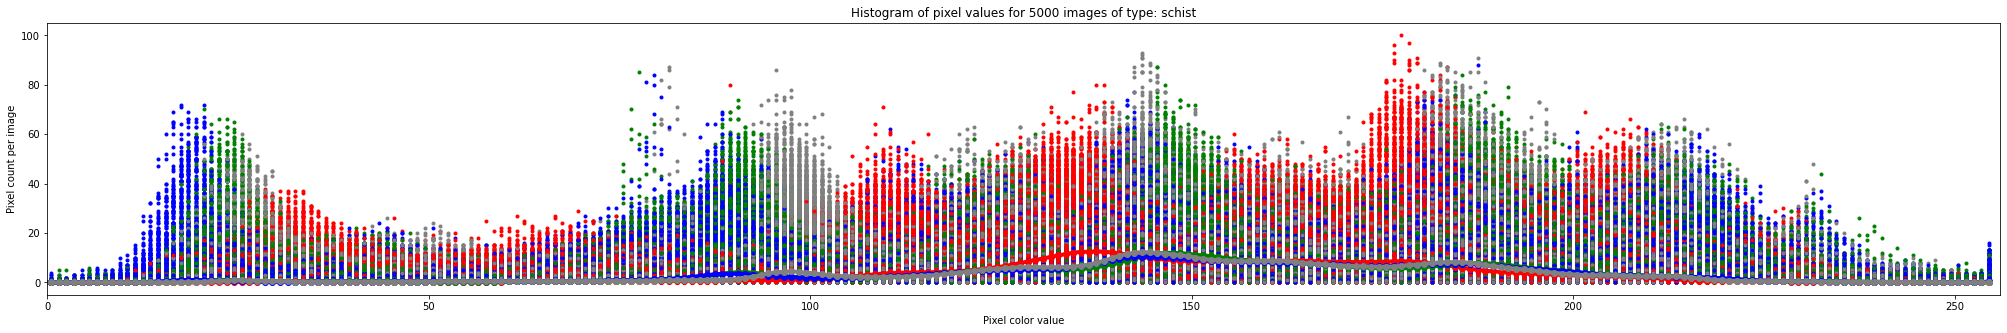

Histogram array created for: quartzite
Histogram array averaged for: quartzite


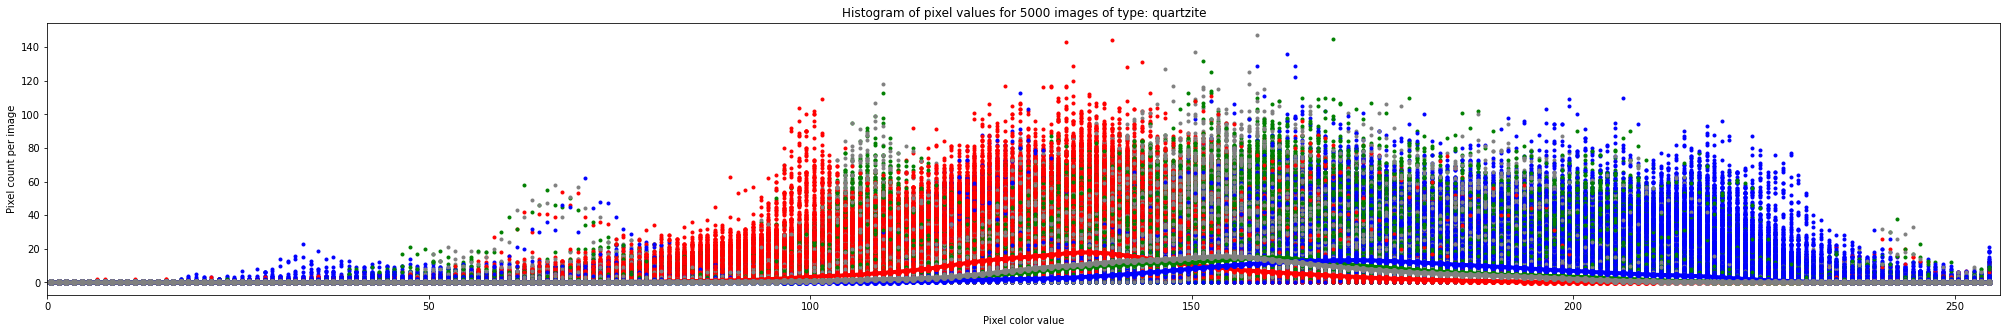

Histogram array created for: andesite
Histogram array averaged for: andesite


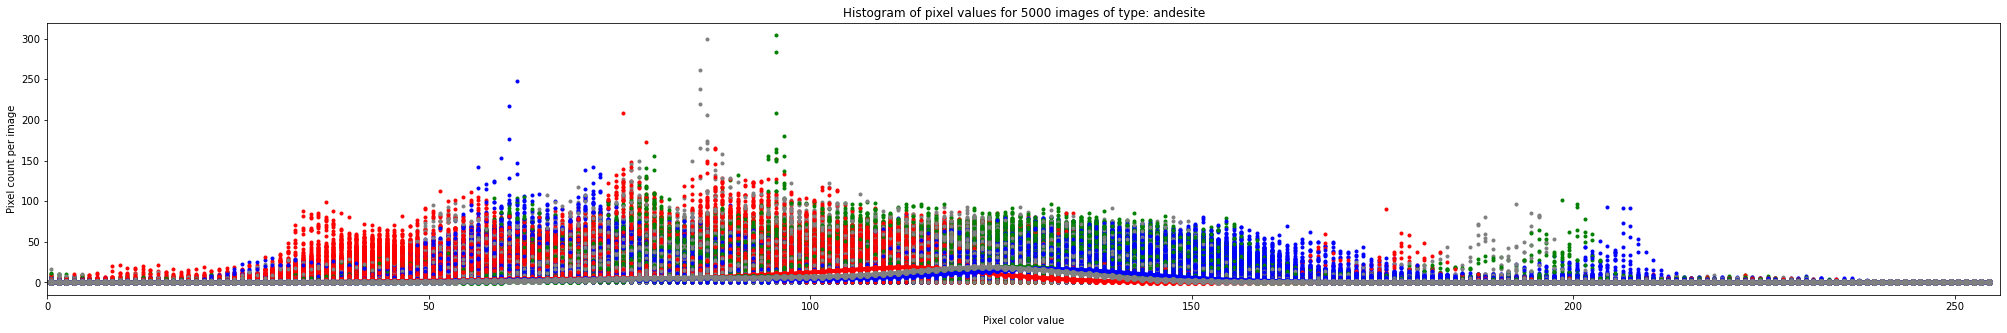

Histogram array created for: rhyolite
Histogram array averaged for: rhyolite


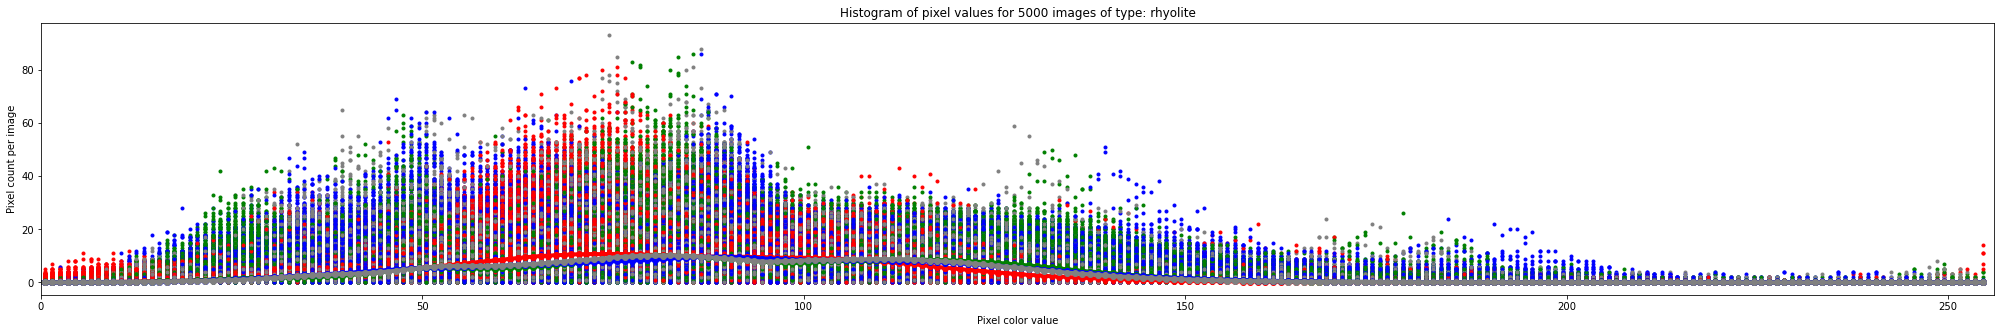

Histogram array created for: gneiss
Histogram array averaged for: gneiss


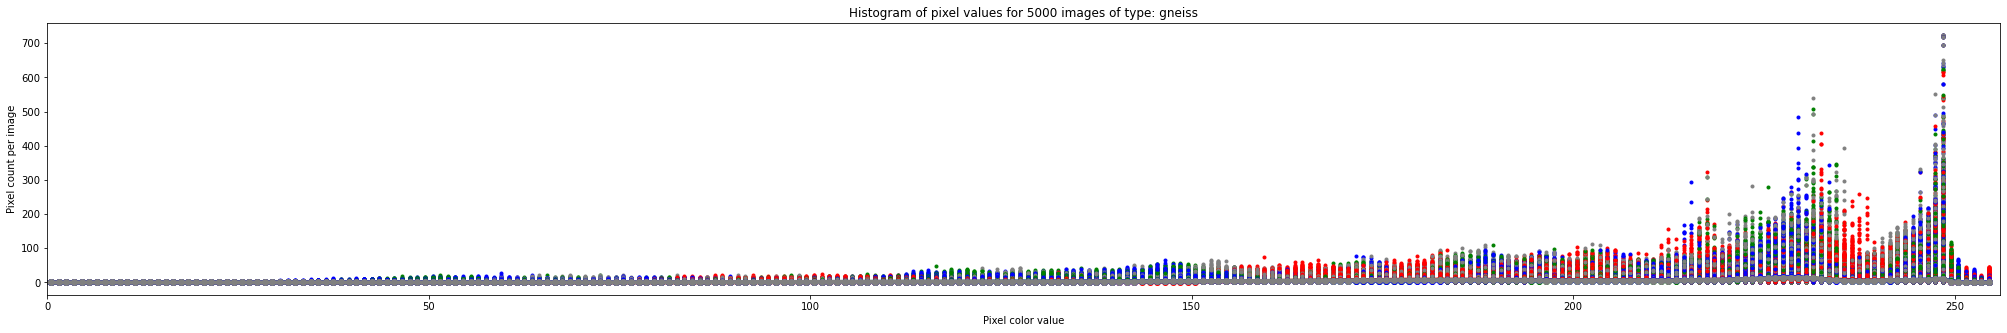

Histogram array created for: marble
Histogram array averaged for: marble


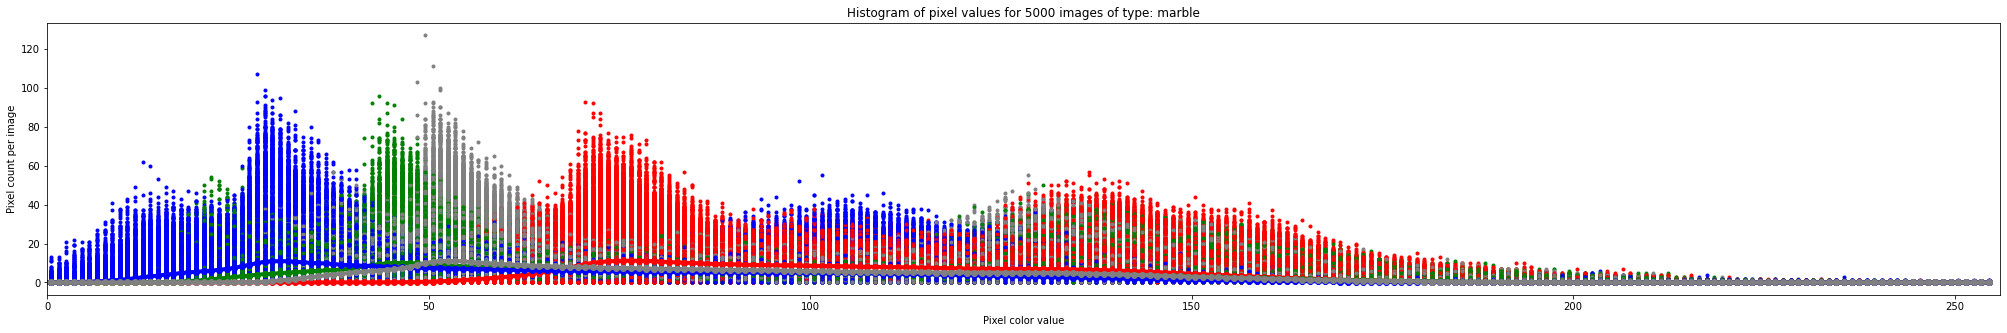

In [14]:
# Create histogram for image pixel data analysis

colors = ("red", "green", "blue", "grey")

for class_type, img_count in type_counts.items():
    color_hist_array = np.zeros((img_count,256,4))

    for i, img_path in enumerate(imgs_df[imgs_df['class']==class_type]['image_path']):
        img = np.array(Image.open(img_path))
        for color_id in range(len(colors)-1):
            histogram, bin_edges = np.histogram(img[:,:,color_id], bins=256, range=(-0.5, 255.5)) 
            color_hist_array[i,:,color_id] = histogram
        grey_img = np.array(ImageOps.grayscale(Image.open(img_path)))
        histogram, bin_edges = np.histogram(grey_img[:,:], bins=256, range=(-0.5, 255.5)) 
        color_hist_array[i,:,3] = histogram
        
    print('Histogram array created for:',class_type)
    avg_color_hist_array = np.mean(color_hist_array, axis=0)    
    print('Histogram array averaged for:',class_type)

    plt.figure(figsize=(35,5))
    plt.xlim([0, 256])
    #plt.ylim([0, 256])
    for i in range(img_count):
        for color_id, c in enumerate(colors):
            plt.plot(bin_edges[0:-1], color_hist_array[i,:,color_id], linewidth=0, marker='.', color=c)
    for color_id, c in enumerate(colors):
        plt.plot(bin_edges[0:-1], avg_color_hist_array[:,color_id], linewidth=4, marker='o', color=c)
    plt.title("Histogram of pixel values for 5000 images of type: "+class_type)
    plt.xlabel("Pixel color value")
    plt.ylabel("Pixel count per image")
    plt.show()

### Observations from histogram plots

schist:
- Highest distibution of brightness, near black to bright
- 6 (or more) distinct clusters of subtypes
- ***Most variable of all 6 classes***

quartzite:
- Wide distibution of brightness, grey to bright
- At least 2 distinct clusters of subtypes
- Usually more <span style="color:blue">***blue in color***</span>
- Usually less red in color

andesite:
- Moderate distribution of brightness, dark to grey
- At least 2 distinct clusters of subtypes
- Sometimes more blue in color

rhyolite:
- Moderate distribution of brightness, near black to grey
- 4 (or more) distinct clusters of subtypes
- Sometimes more blue in color
- Second darkest type

gneiss:
- Most concentrated distribution of brightness, always bright
- ***Brightest of all types***
- 3 (or more) distinct clusters of subtypes

marble:
- Moderate distribution of brightness, near black to grey
- ***Darkest of all types***
- At least 2 distinct clusters of subtypes
- Usually more <span style="color:red">***red in color***</span>
- Usually less blue in color

In [15]:
# Function for plotting different embeddings

def plot_embeddings(X, pixels, title=None):
    
    # Normalize embedding values
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)   

    # Plot all the embeddings
    plt.figure()
    if X.shape[0] <= 6:
        plt.figure(figsize=(5,5))
    else:
        plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    plt.scatter(X[:, 0], X[:, 1], marker='.')
    plt.xticks([]) 
    plt.yticks([])

    # Show thumbnails
    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3 and X.shape[0] > 6:
            continue # don’t show points that are too close
        shown_images = np.r_[shown_images, [X[i]]]

        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(pixels[i,:,:,0:3] / 255), X[i])
        ax.add_artist(imagebox)

https://en.wikipedia.org/wiki/HSL_and_HSV

Pixel arrays created for: schist
TSNE embeddings created for: schist


<Figure size 432x288 with 0 Axes>

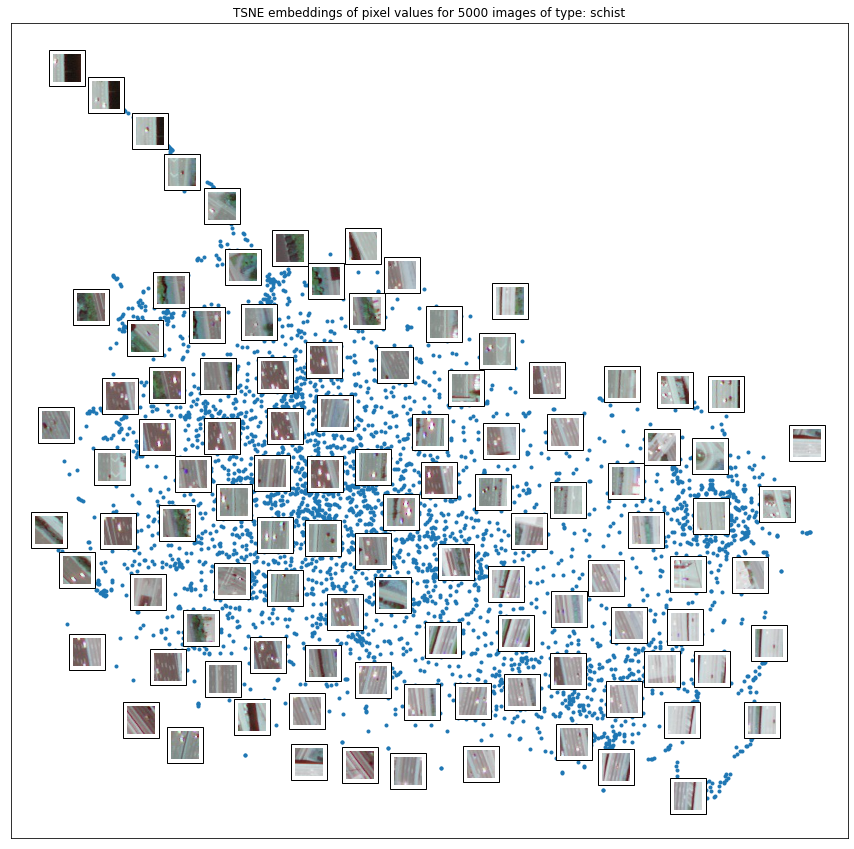

Pixel arrays created for: quartzite
TSNE embeddings created for: quartzite


<Figure size 432x288 with 0 Axes>

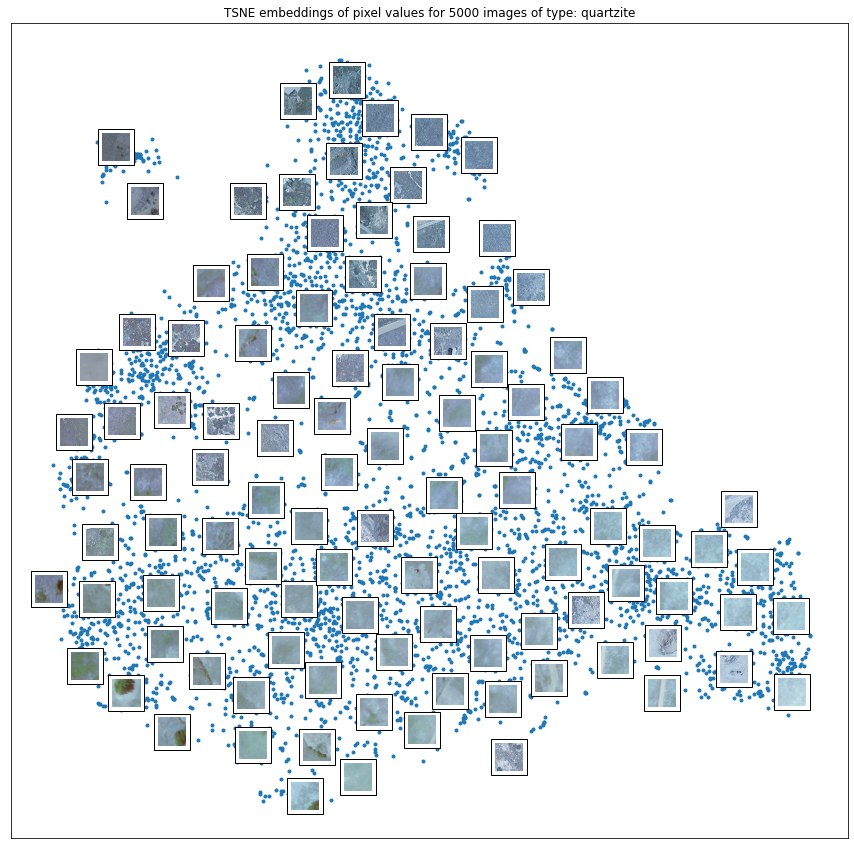

Pixel arrays created for: andesite
TSNE embeddings created for: andesite


<Figure size 432x288 with 0 Axes>

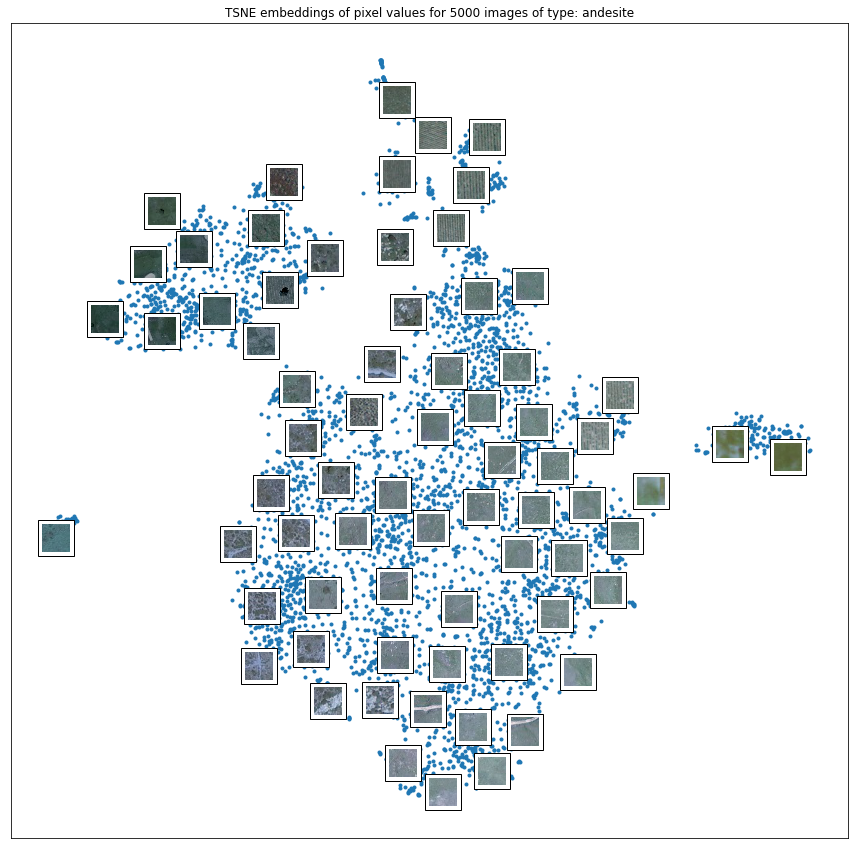

Pixel arrays created for: rhyolite
TSNE embeddings created for: rhyolite


<Figure size 432x288 with 0 Axes>

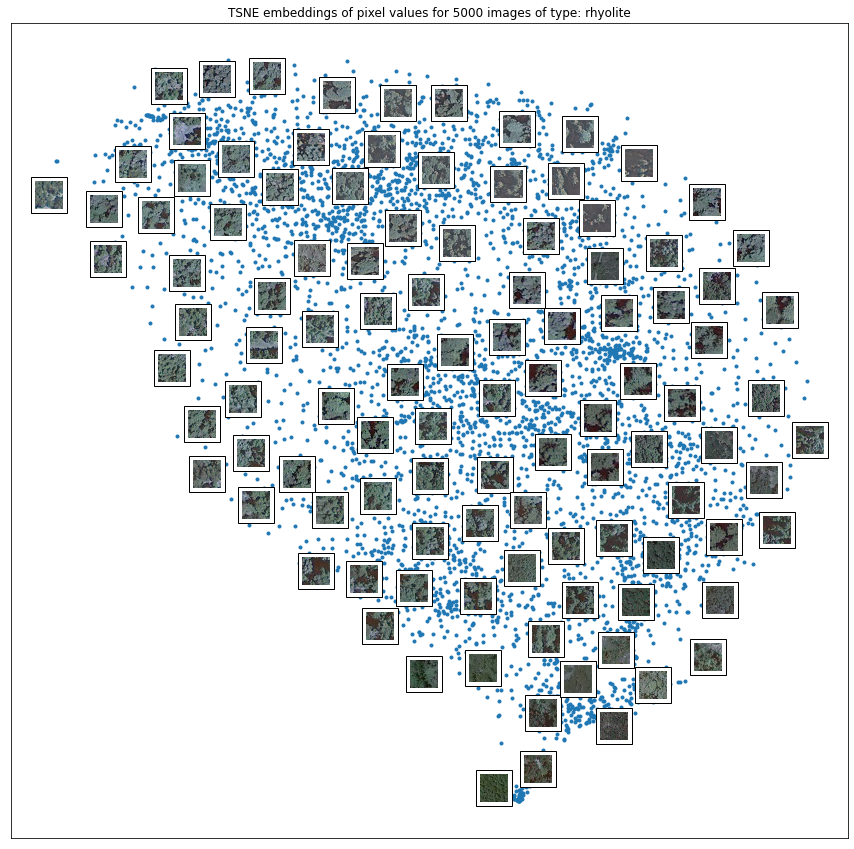

Pixel arrays created for: gneiss
TSNE embeddings created for: gneiss


<Figure size 432x288 with 0 Axes>

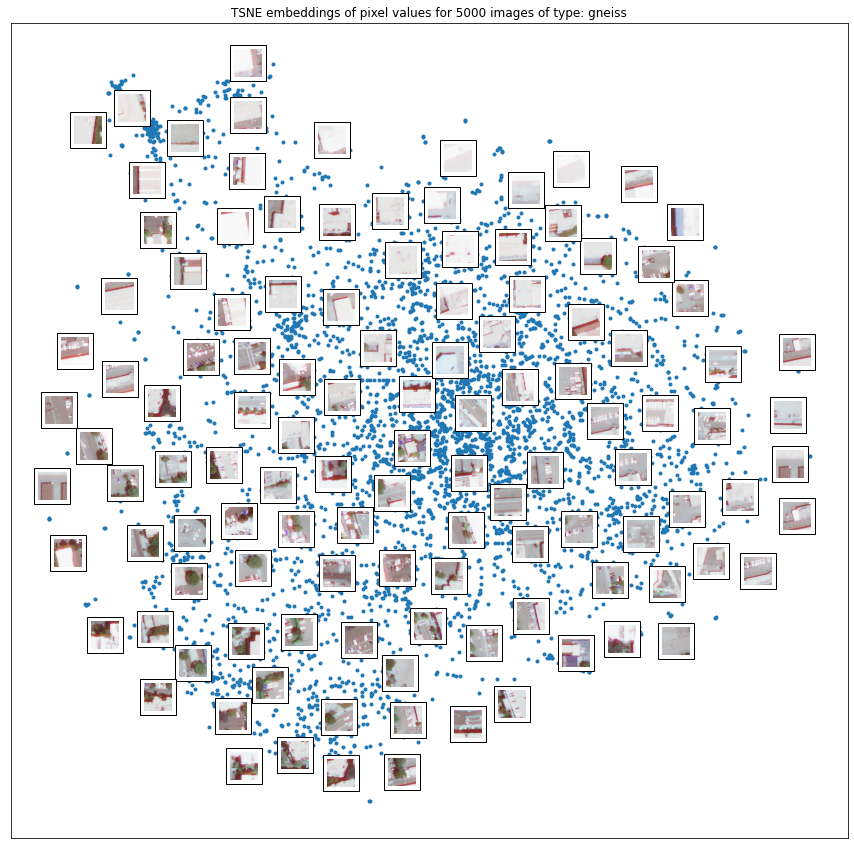

Pixel arrays created for: marble
TSNE embeddings created for: marble


<Figure size 432x288 with 0 Axes>

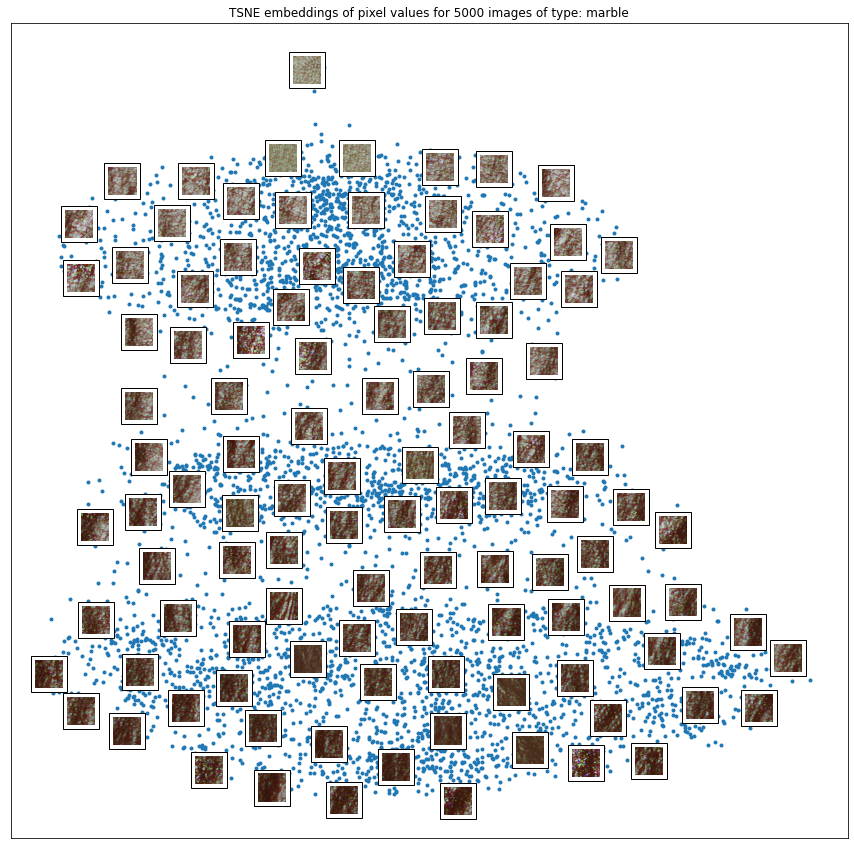

In [16]:
# Calculate and plot TSNE embeddings from HSV colorspace

n_colors = 3

for class_type, img_count in type_counts.items():
    rgb_data = np.zeros((img_count,28,28,n_colors))
    hsv_data = np.zeros((img_count,28,28,n_colors))

    for i, img_path in enumerate(imgs_df[imgs_df['class']==class_type]['image_path']):
        img = Image.open(img_path)
        rgb_data[i,:,:,0:3] = np.array(img)
        img = img.convert('HSV') # alternate color space
        hsv_data[i,:,:,0:3] = np.array(img)
        #pixel_data[i,:,:,3] = np.array(ImageOps.grayscale(img))
    print('Pixel arrays created for:',class_type)

    flat_data = np.reshape(hsv_data, (img_count,28*28*n_colors))
    embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
    print('TSNE embeddings created for:',class_type)
    
    plot_embeddings(embeddings,rgb_data)
    plt.title("TSNE embeddings of pixel values for 5000 images of type: "+class_type)
    plt.show()

In [17]:
# Setup vision transformer model and training data

train_image_paths = [] #to store image paths in list
train_image_class = [] #to store class values

# get all the paths from data_path and append image paths and class to to respective lists
for i, row in imgs_df.iterrows():
    train_image_class.append(row['class']) 
    train_image_paths.append(row['image_path'])
    
train_image_paths = list(flatten(train_image_paths))

idx_to_class = {i:j for i, j in enumerate(imgs_df['class'].unique())}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class MyDataset(torchvision.datasets.VisionDataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        return image, label
    
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()
    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = torch.nn.functional.log_softmax(model(data), dim=1)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

def evaluate(model, data_loader, loss_history):
    model.eval()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = torch.nn.functional.log_softmax(model(data), dim=1)
            loss = torch.nn.functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('Average test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    
data_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(
        (0.50836704, 0.51988116, 0.51973073),(0.18507581, 0.19952308, 0.21939567))])

train_dataset = MyDataset(train_image_paths, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [18]:
# For simplicity, train vision transformer with some default parameters

N_EPOCHS = 2
model = ViT(image_size=28, patch_size=7, num_classes=6, channels=3, dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Only training, no cross-validation or test split
train_loss_history = []
train_acc_history = []

# Minimally train vision transformer
start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, train_loader, train_acc_history)
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/29998 (  0%)]  Loss: 1.9907
[ 6400/29998 ( 21%)]  Loss: 0.3087
[12800/29998 ( 43%)]  Loss: 0.3174
[19200/29998 ( 64%)]  Loss: 0.2557
[25600/29998 ( 85%)]  Loss: 0.3352
Average test loss: 0.1544  Accuracy:28396/29998 (94.66%)

Epoch: 2
[    0/29998 (  0%)]  Loss: 0.1341
[ 6400/29998 ( 21%)]  Loss: 0.1358
[12800/29998 ( 43%)]  Loss: 0.1219
[19200/29998 ( 64%)]  Loss: 0.2472
[25600/29998 ( 85%)]  Loss: 0.2767
Average test loss: 0.1450  Accuracy:28539/29998 (95.14%)

Execution time: 146.46 seconds


Arrays created for: schist
TSNE embeddings created for: schist


<Figure size 432x288 with 0 Axes>

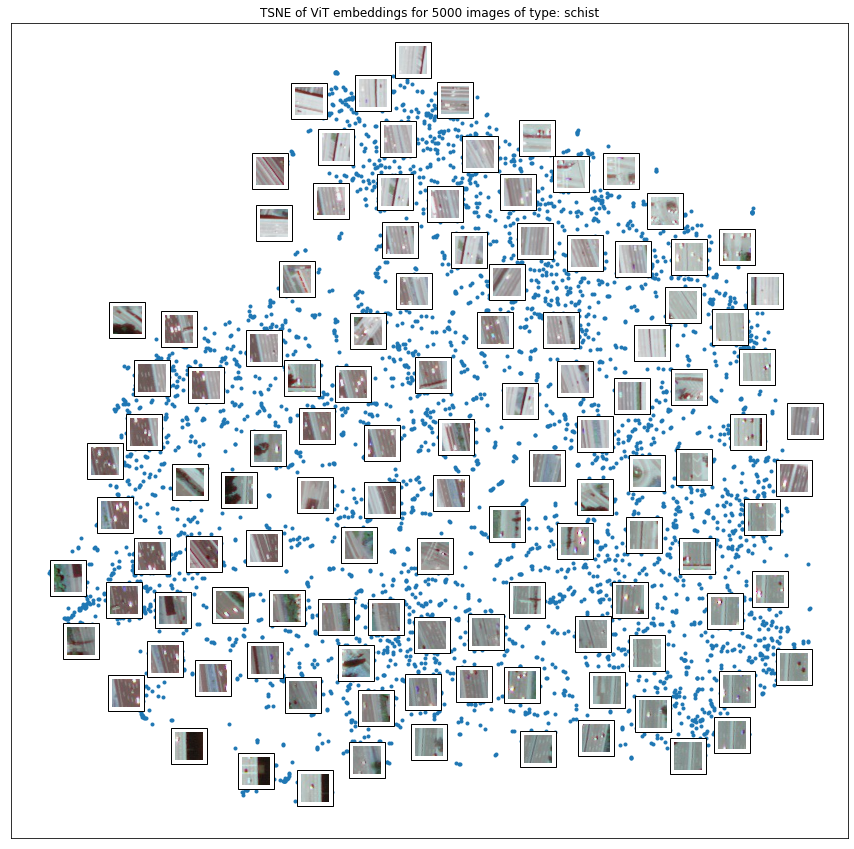

Arrays created for: quartzite
TSNE embeddings created for: quartzite


<Figure size 432x288 with 0 Axes>

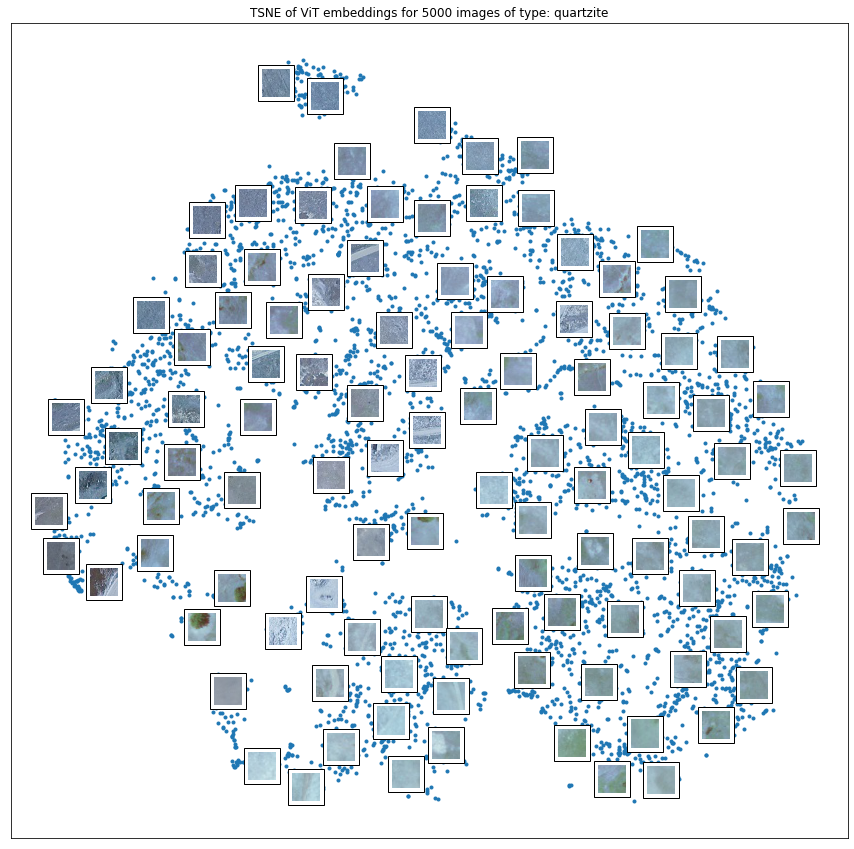

Arrays created for: andesite
TSNE embeddings created for: andesite


<Figure size 432x288 with 0 Axes>

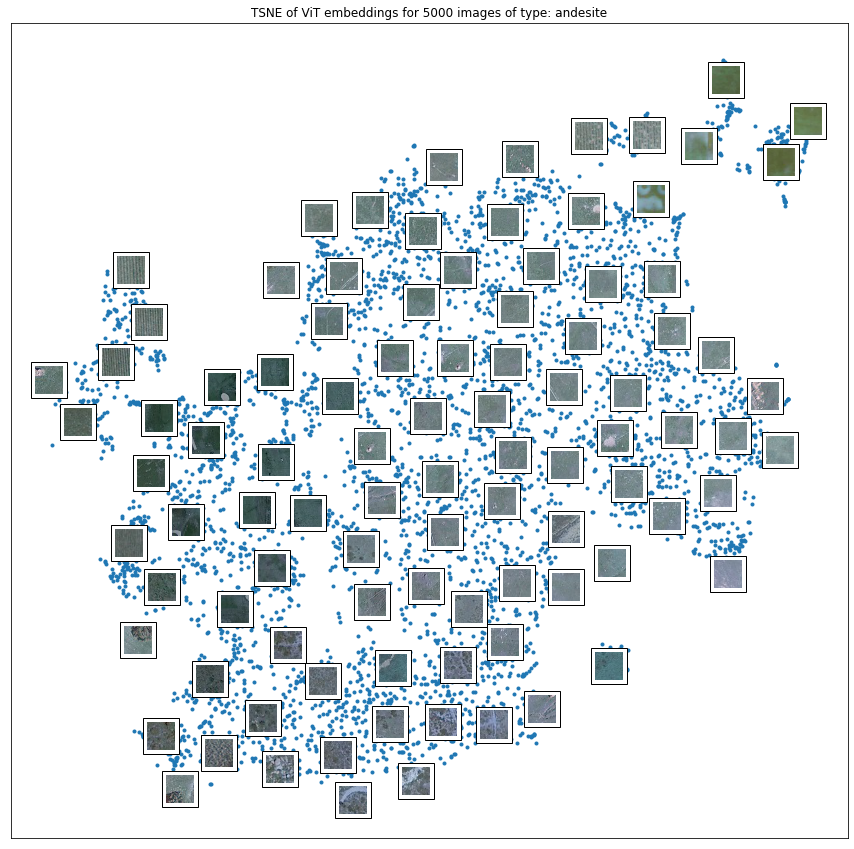

Arrays created for: rhyolite
TSNE embeddings created for: rhyolite


<Figure size 432x288 with 0 Axes>

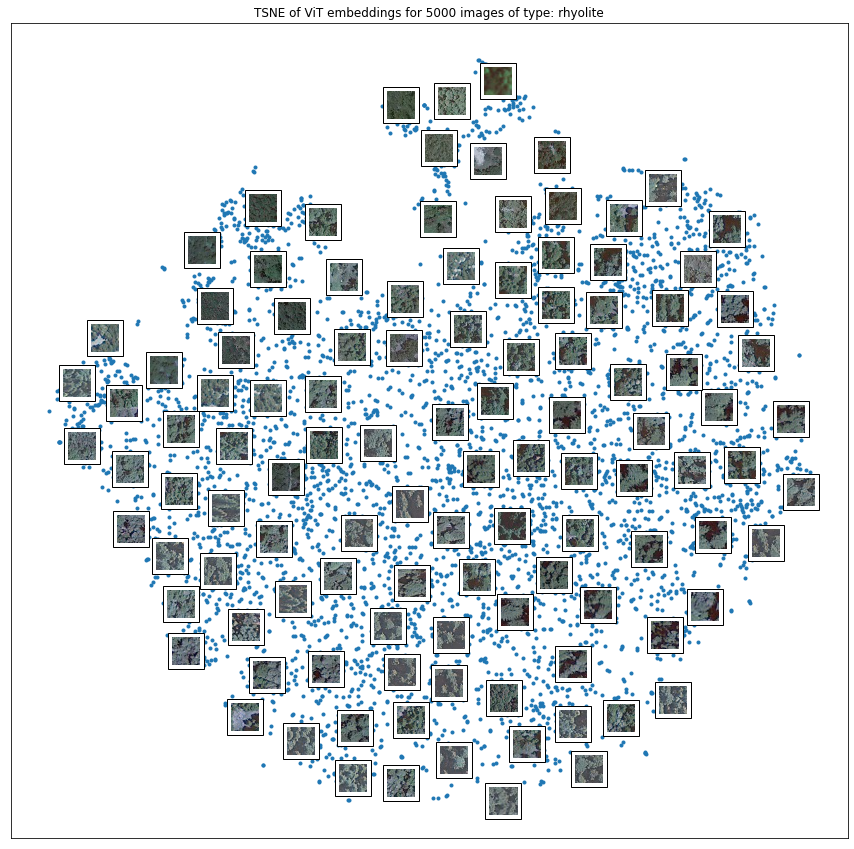

Arrays created for: gneiss
TSNE embeddings created for: gneiss


<Figure size 432x288 with 0 Axes>

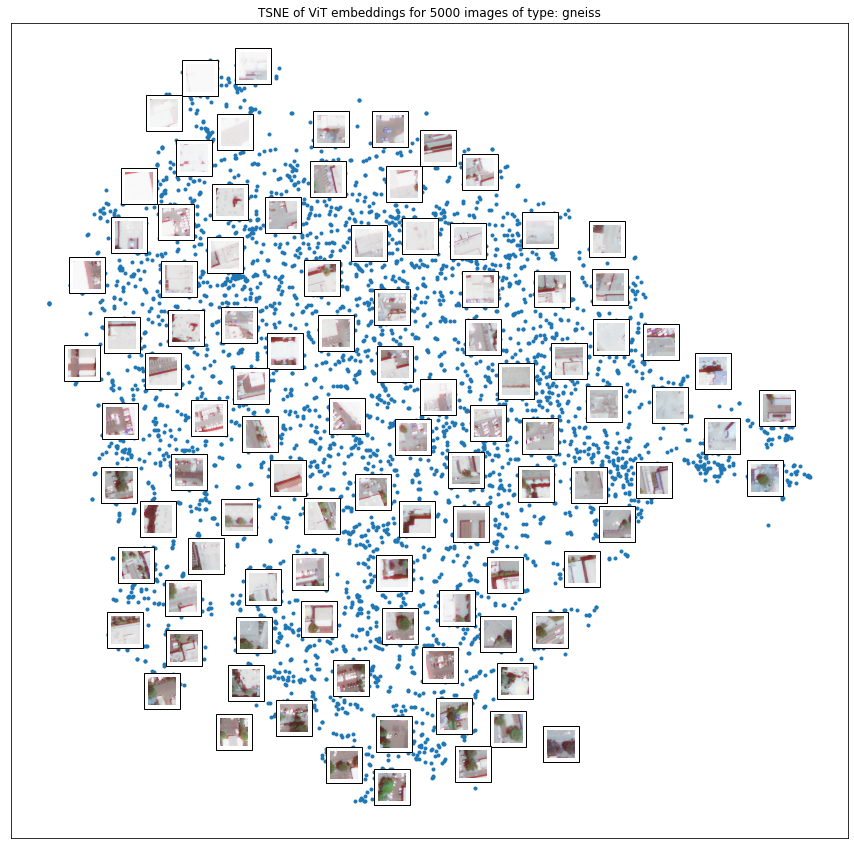

Arrays created for: marble
TSNE embeddings created for: marble


<Figure size 432x288 with 0 Axes>

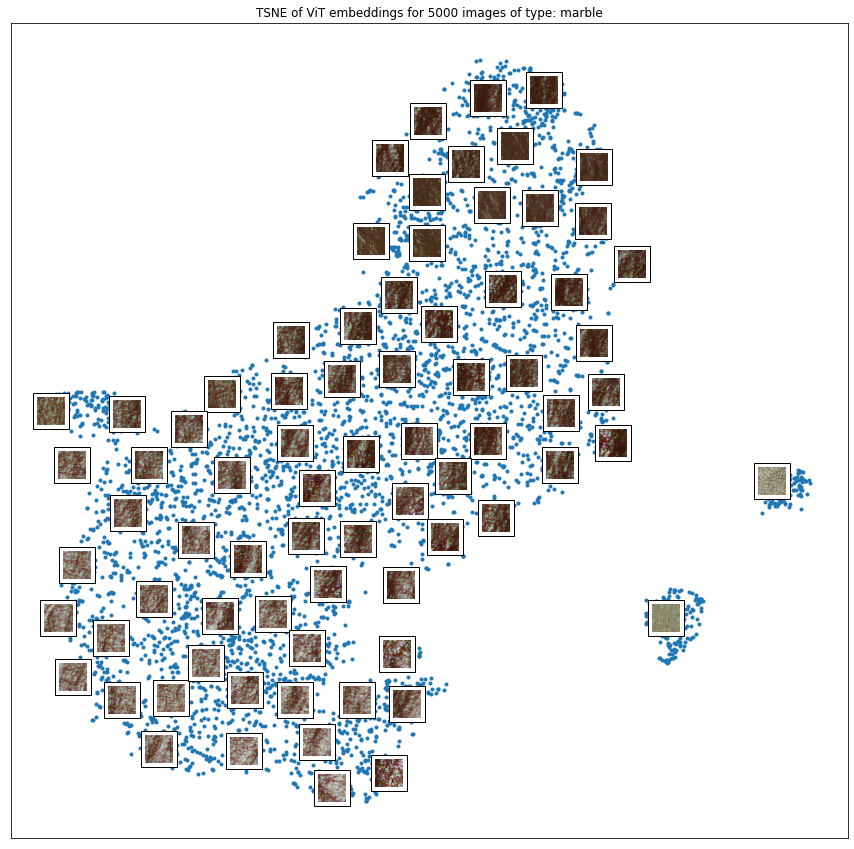

In [19]:
# Extract and plot embeddings from vision transformer model

embed_model = Extractor(model)

for class_type, img_count in type_counts.items():
    rgb_data = np.zeros((img_count,28,28,3))
    nn_embed = np.zeros((img_count,17,64))
    
    img_paths = list(flatten(imgs_df[imgs_df['class']==class_type]['image_path']))
    dataset = MyDataset(img_paths, transform=data_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    for i, (data, target) in enumerate(loader):
        rgb_data[i,:,:,0:3] = np.array(Image.open(img_paths[i]))
        logits, embed = embed_model(data)
        nn_embed[i,:,:] = embed
    print('Arrays created for:',class_type)

    flat_data = np.reshape(nn_embed, (img_count,17*64))
    embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
    print('TSNE embeddings created for:',class_type)
    
    plot_embeddings(embeddings,rgb_data)
    plt.title("TSNE of ViT embeddings for 5000 images of type: "+class_type)
    plt.show()

Arrays created for: ALL IMAGES
TSNE embeddings created for: ALL IMAGES


<Figure size 432x288 with 0 Axes>

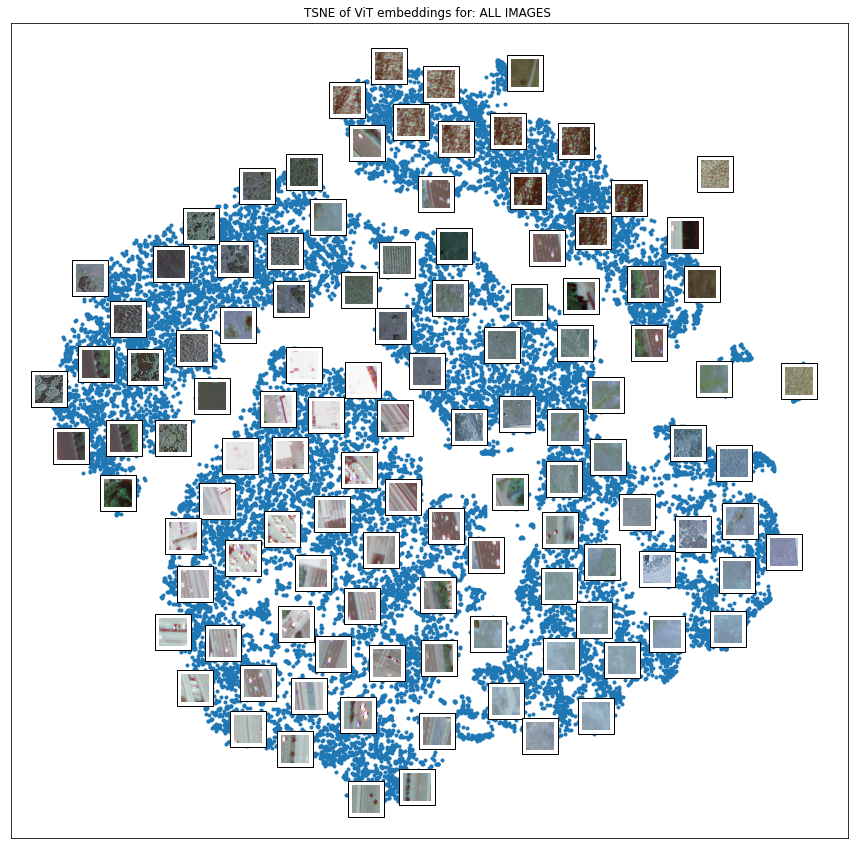

In [20]:
# Extract and plot ALL embeddings from vision transformer model

img_count = len(imgs_df)
rgb_data = np.zeros((img_count,28,28,3))
nn_embed = np.zeros((img_count,17,64))

img_paths = list(flatten(imgs_df['image_path']))
dataset = MyDataset(img_paths, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

for i, (data, target) in enumerate(loader):
    rgb_data[i,:,:,0:3] = np.array(Image.open(img_paths[i]))
    logits, embed = embed_model(data)
    nn_embed[i,:,:] = embed
print('Arrays created for: ALL IMAGES')

flat_data = np.reshape(nn_embed, (img_count,17*64))
embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
print('TSNE embeddings created for: ALL IMAGES')

plot_embeddings(embeddings,rgb_data)
plt.title("TSNE of ViT embeddings for: ALL IMAGES ")
plt.show()

<Figure size 432x288 with 0 Axes>

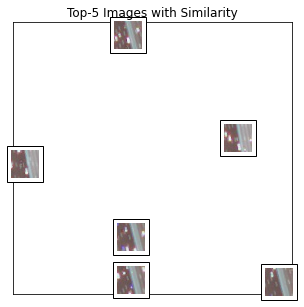

In [38]:
# Return and plot top-5 similar images

rand_img_idx = random.randint(0,len(imgs_df)-1)
img_loc = embeddings[rand_img_idx].reshape(1, -1)

nbrs = NearestNeighbors(n_neighbors=6).fit(embeddings)
indices = nbrs.kneighbors(img_loc, return_distance=False)[0]

top_five_emb = np.zeros((6,2))
top_five_rgb = np.zeros((6,28,28,3))

for i in range(6):
    top_five_emb[i,:] = embeddings[indices[i],:]
    top_five_rgb[i,:,:,:] = rgb_data[indices[i],:,:,:]

plot_embeddings(top_five_emb,top_five_rgb)
plt.title("Top-5 Images with Similarity")
plt.show()